In [ ]:
import mmcv
from mmdet.datasets.transforms import CLAHE
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector

# Show the results
from mmcv.transforms import LoadImageFromFile, Compose, Resize
import matplotlib.pyplot as plt
import cv2

# Specify the path to model config and checkpoint file
config_file = '/home/roberto/PythonProjects/S2RAWVessel/checkpoints/20230515_120308_0.0005/retinanet_r18_fpn_1x_vessels.py'
checkpoint_file = '/home/roberto/PythonProjects/S2RAWVessel/checkpoints/20230515_120308_0.0005/epoch_162.pth'

# Build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# Init visualizer
visualizer = VISUALIZERS.build(model.cfg.visualizer)
# The dataset_meta is loaded from the checkpoint and
# then pass to the model in init_detector
visualizer.dataset_meta = model.dataset_meta


In [9]:
import mmcv
from mmdet.datasets.transforms import CLAHE,ByteScale
from mmengine.utils import track_iter_progress
from mmdet.registry import VISUALIZERS
from mmdet.apis import init_detector, inference_detector

# Show the results
from mmcv.transforms import LoadImageFromFile, Compose, Resize, RandomFlip
from mmdet.datasets.transforms.colorspace import AutoContrast, Contrast, Equalize, Sharpness
import matplotlib.pyplot as plt
import cv2
import numpy as np

import kornia as K
from kornia.io import ImageLoadType
from kornia.core import Tensor
import torch

In [3]:
loader = LoadImageFromFile(to_float32=False, color_type='color', imdecode_backend='tifffile', backend_args=None)
resize = Resize(scale=(2816, 2816), keep_ratio=True)
byte_scale = ByteScale()
autoContrast = AutoContrast(prob=1, level=None, min_mag=1.6, max_mag=1.7)
contrast = Contrast(prob=1, level=None, min_mag=1.3, max_mag=1.3)
equalize = Equalize(prob=1, level=None, min_mag=0.1, max_mag=0.1) # max_mag=1.9
sharpness = Sharpness(prob=1, level=None, min_mag=0.3, max_mag=0.3)

In [20]:
rf1 = RandomFlip(prob=1., direction='horizontal') 
rf2 = RandomFlip(prob=1., direction='vertical') 

In [21]:
img_path = '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/vessels/imgs/day1_g_22_coreg.tif'  # or img = mmcv.imread(img), which will only load it once
res = loader(results={'img_path': img_path})
res = byte_scale(res)
res = resize(res)
res = rf1(res)
res = rf2(res)


CDF min: 0.6449109005015927
CDF max: 1.0


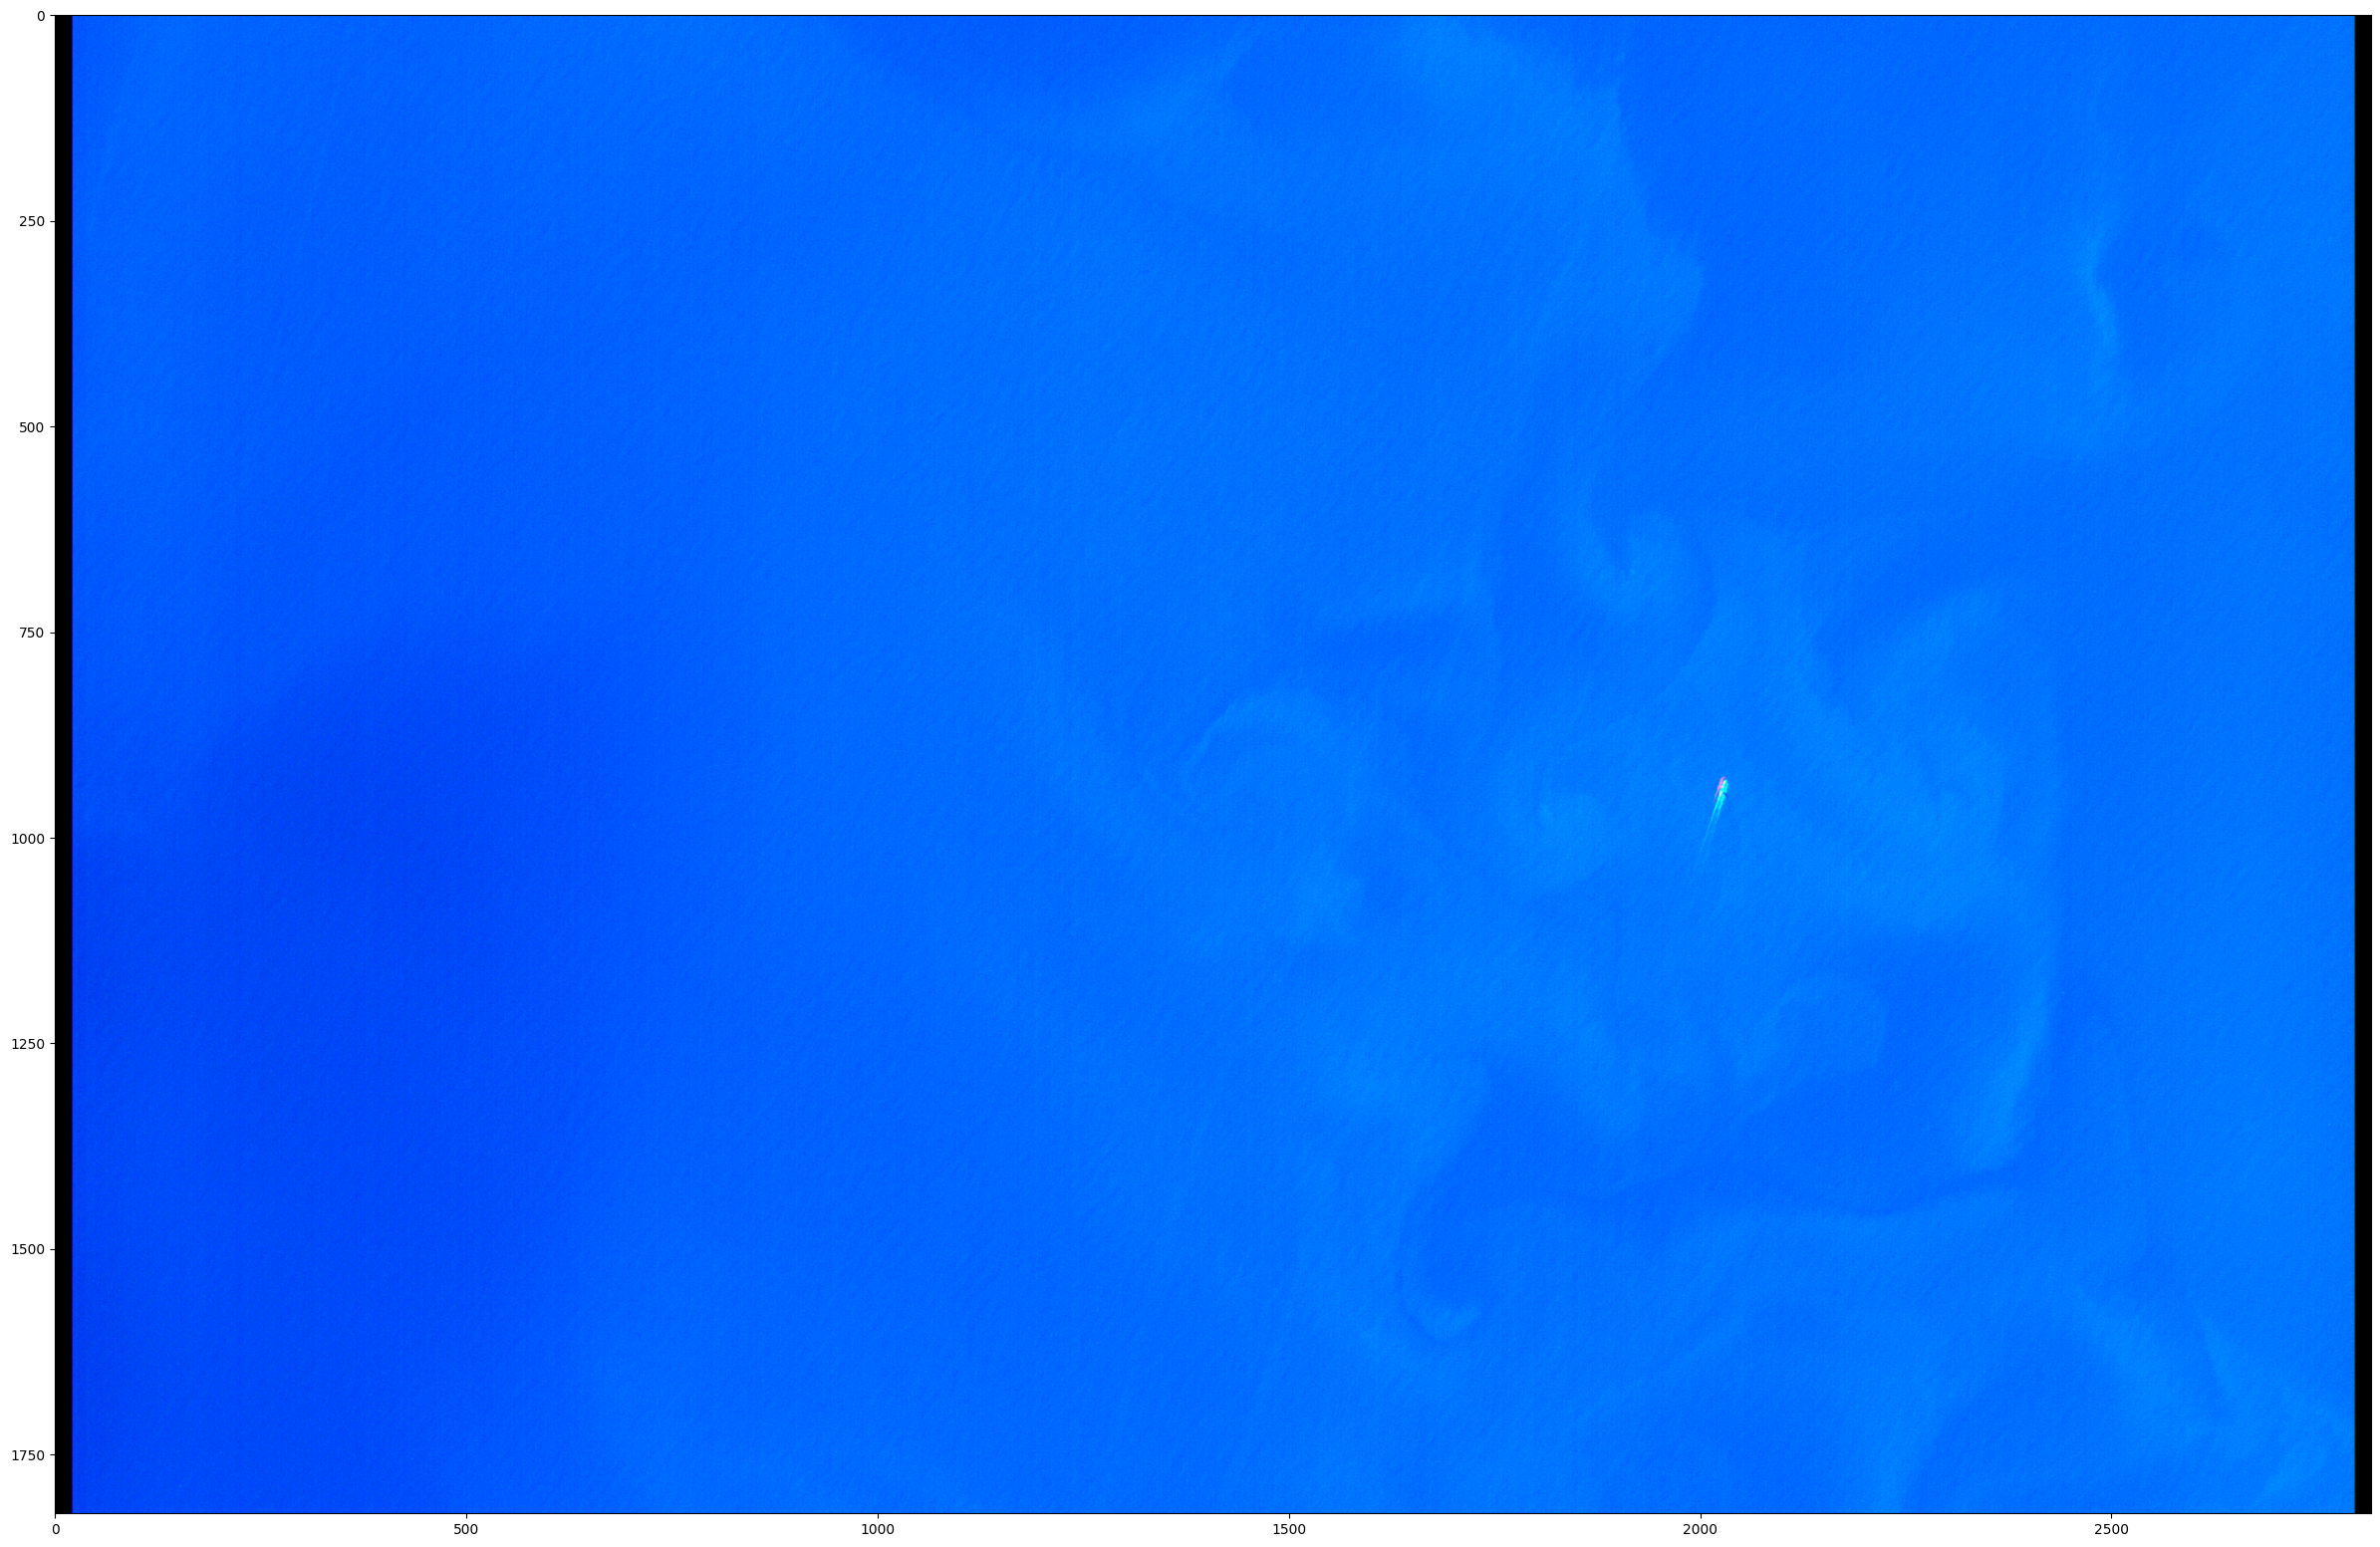

In [22]:
res

plt.figure(figsize=(30, 30))
# plot tensor image
plt.imshow(res['img'][:,:,::-1])
plt.show() 

In [ ]:
img_path = '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/vessels/imgs/day1_g_22_coreg.tif'  # or img = mmcv.imread(img), which will only load it once
res = loader(results={'img_path': img_path})
img = res['img'].astype('float32')
print(img.max())
# hist plot img
plt.figure(figsize=(3, 3))
plt.hist(img.flatten(), bins=100)
plt.show()

# img = np.clip(img, 0, 300)
img /= 10000

def pipeline():
    # to tensor:
    img = torch.from_numpy(img).permute(2, 0, 1).float()
    # tensor_img = K.enhance.equalize(img)
    tensor_img = K.enhance.equalize_clahe(img, clip_limit=10.0, grid_size=(16, 16), slow_and_differentiable=False)
    tensor_img = K.enhance.adjust_contrast(tensor_img, factor=1., clip_output=True)

    plt.figure(figsize=(20, 20))
    # plot tensor image
    plt.imshow(tensor_img.permute(1, 2, 0).cpu().numpy()[:,:,::-1])
    plt.show()
    
# equalize img
def equalize_3d_array(arr):
    # Flatten the 3D array into a 1D array
    flat_arr = arr.ravel()

    # Calculate the histogram of values
    hist, bins = np.histogram(flat_arr, bins=256, range=(0, 1))

    # Calculate the cumulative distribution function (CDF)
    cdf = hist.cumsum()
    # Normalize the CDF to [0, 1]
    cdf_normalized = cdf / cdf[-1]

    # Use linear interpolation to equalize the values
    equalized_arr = np.interp(flat_arr, bins[:-1], cdf_normalized)

    # Reshape the equalized array back to its original shape
    equalized_arr = equalized_arr.reshape(arr.shape)

    return equalized_arr

def enhance_contrast(arr, cdf_min_percentile=0, cdf_max_percentile=98):
    # Reshape the 3D array to 2D
    flat_arr = arr.reshape(-1)

    # Compute the cumulative histogram of the flattened array
    hist, bins = np.histogram(flat_arr, bins=256, range=(0, 1))
    cum_hist = hist.cumsum()

    # Normalize the cumulative histogram
    cum_hist_normalized = cum_hist / cum_hist[-1]

    # Calculate the minimum and maximum CDF values based on percentiles
    cdf_min = np.percentile(cum_hist_normalized, cdf_min_percentile)
    print(f"CDF min: {cdf_min}")
    cdf_max = np.percentile(cum_hist_normalized, cdf_max_percentile)
    print(f"CDF max: {cdf_max}")
    # Map the equalized values to the original array within the specified CDF range
    equalized_arr = np.interp(flat_arr, bins[:-1], (cum_hist_normalized - cdf_min) / (cdf_max - cdf_min))

    # Clip values outside of the range 0-1
    equalized_arr = np.clip(equalized_arr, 0, 1)

    # Reshape the equalized array back to the original shape
    equalized_arr = equalized_arr.reshape(arr.shape)

    return equalized_arr



# img = equalize_3d_array(img)
    
img = enhance_contrast(img, cdf_min_percentile=1.1, cdf_max_percentile=100)
    
plt.figure(figsize=(30, 30))
# plot tensor image
plt.imshow(img[:,:,::-1])
plt.show() 


In [ ]:
img

In [ ]:
i

In [ ]:
import cv2
import numpy as np
import clahe

def bytescale_12_to_8_enhanced(img):
    # ensure the value is within 12-bit range
    img = np.clip(img, 0, 2000)
    # scale values from 12-bit to 8-bit
    # img = ((img / img.max()) * 255).astype(np.uint8)
    img = (img / img.max() * 255).astype(np.uint8)
    # apply CLAHE
    return img


In [ ]:
img_ = res['img'][:,:,::-1]
img_eq = bytescale_12_to_8_enhanced(img_)
# plot histogram of pixel intensity
plt.hist(img_eq.ravel(), bins=256, range=(0.0, 255), fc='k', ec='k')
plt.show()
plt.imshow(img_eq)
plt.show()

In [ ]:

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the histogram
ax1.hist(img_eq[:,:,0], bins=256, range=(0.0, 255), fc='k', ec='k')
ax1.set_title('Histogram')
ax1.set_xlabel('Pixel Value')
ax1.set_ylabel('Frequency')

# Plot the equalized image
ax2.imshow(img_eq[:,:,0], cmap='gray')
ax2.set_title(f'Equalized Image')
ax2.axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Display the figure
plt.show()

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(img_8['img'][:,:,::-1])
plt.show()

In [ ]:
Normalization = CLAHE(clip_limit=1, tile_grid_size=(128, 128))

In [ ]:
equalize?

In [ ]:
contrast = Contrast(prob=1, level=None, min_mag=1.9, max_mag=1.9)
equalize = Equalize(prob=1, level=None, min_mag=0.1, max_mag=1.9) # max_mag=1.9

# Test a single image and show the results
img_path = '/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/vessels/imgs/day8_g_25_coreg.tif'  # or img = mmcv.imread(img), which will only load it once
res = loader(results={'img_path': img_path})
res = Normalization(res)
# res = autoContrast(res)
# res = contrast(res)
res = equalize(res)

# resized = resize(load)
# norm = Normalization(resized)
plt.figure(figsize=(12,12))
plt.imshow(res['img'])
plt.axis(False)
plt.show()

In [ ]:
import cv2
import clahe
import matplotlib.pyplot as plt
import numpy as np

# read all three channels:
img = cv2.imread(filename='/home/roberto/PythonProjects/S2RAWVessel/mmdetection/data/vessels/imgs/day8_g_29_coreg.tif', flags=cv2.IMREAD_ANYDEPTH | cv2.IMREAD_COLOR)
print(img.min(), img.max())

In [ ]:
img

In [ ]:
# grad_clip img
img = np.clip(img, 0, 600)
# apply clahe over the three channels and then merge them back:
im_a = clahe.clahe(img[:,:,0], clip_limit=2, win_shape=(512,512))
im_b = clahe.clahe(img[:,:,1], clip_limit=2, win_shape=(512,512))
im_c = clahe.clahe(img[:,:,2], clip_limit=2, win_shape=(512,512))

# merge them back:
img = np.dstack((im_a, im_b, im_c))

# rewrite the same process as function:
def clahe_rgb(img, clip_limit=2, win_shape=(512,512)):
    im_a = clahe.clahe(img[:,:,0], clip_limit=clip_limit, win_shape=win_shape)
    im_b = clahe.clahe(img[:,:,1], clip_limit=clip_limit, win_shape=win_shape)
    im_c = clahe.clahe(img[:,:,2], clip_limit=clip_limit, win_shape=win_shape)
    return np.dstack((im_a, im_b, im_c))




In [ ]:
plt.figure(figsize=(16,16))
plt.imshow(img, cmap='gray')
plt.axis(False)
plt.show()

In [ ]:
# def normalize(img):
#     # Normalize
#     minimum = np.min(img)
#     maximum = np.max(img)
#     mean = np.mean(img)
#     std = np.std(img)
    
    
#     return stretched

In [ ]:
# plot the histogram of im_c
import numpy as np

plt.figure(figsize=(10,10))
plt.hist(im_c.flatten(), bins=256)
plt.show()
    

In [ ]:
im_c

In [ ]:
# print(img)
# # Log Scaling:
# img = np.log(img)
# # Normalization:
# img = (img - np.mean(img)) / np.std(img)
# # Rescaling:
# # img = img * 255
# # plotting:
# plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.axis(False)
# print(img)

In [ ]:
img

In [ ]:
# plot histogram of pixel intensity
plt.figure(figsize=(10,10)) 
plt.hist(img.ravel(), bins=1256, range=(0.0, 200.0), fc='k', ec='k')
plt.show()

In [ ]:
l2 = resize(l1)
l2

In [ ]:
%cd /home/roberto/PythonProjects/S2RAWVessel/mmdetection

In [ ]:
from mmdet.models.data_preprocessors.data_preprocessor import DetDataPreprocessor

In [ ]:
pre_pro=DetDataPreprocessor(mean=[200, 154, 116],
                    std=[22, 24, 27],
                    bgr_to_rgb=False,
                    pad_size_divisor=32)

In [ ]:
pre_pro

In [ ]:
img = l2['img']

plt.figure(figsize=(20, 20))
plt.imshow(img)

In [ ]:
# result = inference_detector(model, img)

# img = mmcv.imread(img)
# img = mmcv.imconvert(img, 'bgr', 'rgb')

# result = inference_detector(model, img)


# visualizer.add_datasample(
#     'result',
#     img,
#     data_sample=result,
#     draw_gt=False,
#     show=True)

In [ ]:
visualizer.show()

In [ ]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from pathlib import Path
import numpy as np
import mmcv
import matplotlib.pyplot as plt
import cv2
###############################################################
# config_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/Cascade_Mask_RCNN.py'
# checkpoint_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/epoch_10.pth'
# # build the model from a config file and a checkpoint file
# model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [ ]:
config_file = '/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/checkpoints/SARWake/mask50/mask50_2023-01-29T16:53:13_768_25e_SARWake_lr_0.002_CosineAnnealing/Mask_RCNN_r50.py'
checkpoint_file = '/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/checkpoints/SARWake/mask50/mask50_2023-01-29T16:53:13_768_25e_SARWake_lr_0.002_CosineAnnealing/epoch_25.pth'
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [ ]:
img_path = 'Images/SEASAR/Sen1/Screenshot 2023-01-29 alle 20.15.22 (copy).png'


img_path = Path(img_path)
img = cv2.imread(img_path.as_posix())
shape = mmcv.imread(img_path).shape[0]
result = inference_detector(model, img)
out_file = f'/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/Images/SEASAR/D_'+img_path.stem + '.png'

print(out_file)
model.show_result(
     img,
     result,
     score_thr=0.3,
     show=True,
     wait_time=0,
     win_name=None,
     bbox_color=(0, 255, 255),
     text_color=(255, 255, 255),
     thickness=5,
     font_size=shape//40,
     mask_color=(0, 255, 255),
     out_file=out_file)


# Crateri

In [ ]:
config_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/Cascade_Mask_RCNN.py'
checkpoint_file = 'checkpoints/Craters/cascade_mask50/cascade_mask50_2022-08-05T15:15:10_768_25e_Craters_lr_0.002_CosineAnnealing/epoch_10.pth'
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

# test a single image
import matplotlib.pyplot as plt
import cv2

images = Path('Images_craters').glob('**/*')
for img_path in images:
     img = cv2.imread(img_path.as_posix())
     shape = mmcv.imread(img_path).shape[0]

     result = inference_detector(model, img)
     out_file = f'Images_craters/F_'+img_path.name
     # out_file = None
     print(out_file)
     model.show_result(
          img,
          result,
          score_thr=0.7,
          show=True,
          wait_time=0,
          win_name=None,
          bbox_color=(0, 255, 255),
          text_color=(255, 255, 255),
          thickness=5,
          font_size=shape//40,
          mask_color=None,
          out_file=out_file)

# Multi-Spectral Wakes

In [ ]:
config_file = 'checkpoints/B4/retina_swin/retina_swin_2022-07-28T22:15:36_768_50e_B4_lr_0.001_step/retinanet_swin-t-p4-w7_fpn_1x_coco.py'
checkpoint_file = 'checkpoints/B4/retina_swin/retina_swin_2022-07-28T22:15:36_768_50e_B4_lr_0.001_step/epoch_44.pth'
# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')

In [ ]:
import pandas as pd 

img = cv2.imread("/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/Images/test_Landsat9/VIEW2.png")
img = img[350:-350,170:-170]
result = inference_detector(model, img)
out_file = f'Images/test_Landsat9/img.png'
# out_file = None
print(out_file)
shape = mmcv.imread("Images/test_Landsat9/WhatsApp Image 2022-08-29 at 14.35.43 (1).jpeg").shape[0]

model.show_result(
     img,
     result,
     score_thr=0.5,
     show=True,
     wait_time=0,
     win_name=None,
     bbox_color=(0, 255, 255),
     text_color=(255, 255, 255),
     thickness=5,
     font_size=shape//20,
     mask_color=None,
     out_file=out_file)

In [ ]:
# test a single image
import os
#################################################################
OUTDIR='Images/IAC22'
bands = ['B2','B3','B4','B8']
for band in bands:
     img_path = f'data/DATASETS/{band}/val2017/subset_4_of_S2A_MSIL2A_20210628T103021_N0300_R108_T33VUD_20210628T152020.png'
     # data/DATASETS/B4/val2017/subset_4_of_S2A_MSIL2A_20210628T103021_N0300_R108_T33VUD_20210628T152020.png
     img_path = Path(img_path)
     Name = img_path.stem
     shape = mmcv.imread(img_path.as_posix()).shape[0]
     img = cv2.imread(img_path.as_posix())
     
     result = inference_detector(model, img)
     out_file = f'{OUTDIR}/{band}.png'
     # out_file = None
     print(out_file)
     model.show_result(
          img,
          result,
          score_thr=0.4,
          show=True,
          wait_time=0,
          win_name=None,
          bbox_color=(0, 255, 255),
          text_color=(255, 255, 255),
          thickness=5,
          font_size=shape//20,
          mask_color=None,
          out_file=out_file)

#################################################################
#################################################################

fig, ax = plt.subplots(1,4, sharex=True, sharey=True, dpi=250, figsize=(10,10))
i = 0
for band in bands:
     img_path = f'Images/IAC22/{band}.png'
     img_path = Path(img_path)
     img =cv2.cvtColor(cv2.imread(img_path.as_posix()), cv2.COLOR_BGR2RGB)
     ax[i].imshow(img)
     ax[i].set_xlabel(band)
     ax[i].set_yticks([])
     ax[i].set_xticks([])
     i += 1

plt.subplots_adjust(wspace=0.16, hspace=0.1)
plt.show()
# # fig.savefig(f'{OUTDIR}/IMG.eps')
fig.savefig(f'{OUTDIR}/{Name}.png', bbox_inches='tight')


# All network single image

In [ ]:
inference_sel = {'cascade101':['checkpoints/B2/cascade_mask101/cascade_mask101_2022-07-10T18:59:06_712_50e_B2_lr_0.001/Cascade_Mask_RCNN_101.py','checkpoints/B2/cascade_mask101/cascade_mask101_2022-07-10T18:59:06_712_50e_B2_lr_0.001/epoch_36.pth'],
               'vfnet':['checkpoints/B2/vfnet/vfnet_2022-07-16T05:02:19_768_50e_B2_lr_0.001_step/vfnet_r50.py','checkpoints/B2/vfnet/vfnet_2022-07-16T05:02:19_768_50e_B2_lr_0.001_step/epoch_45.pth'],
               'retina18':['checkpoints/B2/retina18/retina18_2022-07-11T20:10:38_768_100e_B2_lr_0.0005_Cosine/RetinaNet_18.py','checkpoints/B2/retina18/retina18_2022-07-11T20:10:38_768_100e_B2_lr_0.0005_Cosine/epoch_70.pth'],
               'retina34':['checkpoints/B2/retina34/retina34_2022-07-20T04:26:10_768_50e_B2_lr_0.001_step/RetinaNet_34.py','checkpoints/B2/retina34/retina34_2022-07-20T04:26:10_768_50e_B2_lr_0.001_step/epoch_48.pth'],
               'retina50':['checkpoints/B2/retina50/retina50_2022-07-09T01:49:52_712_50e_B2_lr_0.001/RetinaNet_50.py','checkpoints/B2/retina50/retina50_2022-07-09T01:49:52_712_50e_B2_lr_0.001/epoch_35.pth'],
               'retina101':['checkpoints/B2/retina101/retina101_2022-07-09T13:47:42_712_50e_B2_lr_0.001/RetinaNet_101.py','checkpoints/B2/retina101/retina101_2022-07-09T13:47:42_712_50e_B2_lr_0.001/epoch_37.pth'],
               'retina_swin':['checkpoints/B2/retina_swin/retina_swin_2022-07-20T18:45:50_768_50e_B2_lr_0.001_CosineAnnealing/retinanet_swin-t-p4-w7_fpn_1x_coco.py','checkpoints/B2/retina_swin/retina_swin_2022-07-20T18:45:50_768_50e_B2_lr_0.001_CosineAnnealing/epoch_37.pth'],
               'fovea101':['checkpoints/B2/fovea101/fovea101_2022-07-19T07:24:39_768_50e_B2_lr_0.001_step/fovea_r101_fpn_4x4_1x_coco.py','checkpoints/B2/fovea101/fovea101_2022-07-19T07:24:39_768_50e_B2_lr_0.001_step/epoch_34.pth'],
               'centernet18':['checkpoints/B2/centernet18/centernet18_2022-07-18T11:03:43_768_50e_B2_lr_0.001_CosineAnnealing/centernet_resnet18_dcnv2.py','checkpoints/B2/centernet18/centernet18_2022-07-18T11:03:43_768_50e_B2_lr_0.001_CosineAnnealing/epoch_38.pth'],
               'faster50':['checkpoints/B2/faster50/faster50_2022-07-18T13:39:06_768_50e_B2_lr_0.001_step/faster_rcnn_r50_fpn.py','checkpoints/B2/faster50/faster50_2022-07-18T13:39:06_768_50e_B2_lr_0.001_step/epoch_43.pth'],
               'mask50':['checkpoints/B2/mask50/mask50_2022-07-10T23:44:13_712_50e_B2_lr_0.001/Mask_RCNN_r50.py','checkpoints/B2/mask50/mask50_2022-07-10T23:44:13_712_50e_B2_lr_0.001/epoch_36.pth'],
               'cascade_hrnet':['checkpoints/B2/hrnet40_cascade/hrnet_cascade_atHand/hrnet402022-07-06T08:56:37_712_40e_B4_lr_0.01/HrNet_w40_cascade.py','checkpoints/B2/hrnet40_cascade/hrnet_cascade_atHand/hrnet402022-07-06T08:56:37_712_40e_B4_lr_0.01/epoch_21.pth'],
               'fcos50':['checkpoints/B2/fcos50/fcos50_2022-07-18T17:27:53_768_50e_B2_lr_0.001_step/fcos_r50_caffe_fpn_gn-head_1x_coco.py','checkpoints/B2/fcos50/fcos50_2022-07-18T17:27:53_768_50e_B2_lr_0.001_step/epoch_49.pth'],
               'retina_eff':['checkpoints/B2/efficientdet/efficientdet_2022-07-17T18:11:09_768_100e_B2_lr_0.001_step/retinanet_effb3_fpn_crop896_8x4_1x_coco.py','checkpoints/B2/efficientdet/efficientdet_2022-07-17T18:11:09_768_100e_B2_lr_0.001_step/epoch_34.pth'],
               'htc50':['checkpoints/B2/htc50/htc50_2022-07-19T17:32:54_768_50e_B2_lr_0.0005_step/htc_without_semantic_r50_fpn_1x_coco.py','checkpoints/B2/htc50/htc50_2022-07-19T17:32:54_768_50e_B2_lr_0.0005_step/epoch_4.pth'],
               'fovea50':['checkpoints/B2/fovea50/fovea50_2022-07-16T13:23:15_768_50e_B2_lr_0.001_CosineAnnealing/fovea_r50_fpn_4x4_1x_coco.py','checkpoints/B2/fovea50/fovea50_2022-07-16T13:23:15_768_50e_B2_lr_0.001_CosineAnnealing/epoch_37.pth'],
               'sparce_rcnn':['checkpoints/B2/sparce_rcnn50/sparce_rcnn50_2022-07-16T16:20:26_768_50e_B2_lr_0.001_CosineAnnealing/sparce_rcnn.py','checkpoints/B2/sparce_rcnn50/sparce_rcnn50_2022-07-16T16:20:26_768_50e_B2_lr_0.001_CosineAnnealing/epoch_48.pth'],
               }
models = list(inference_sel.keys())

In [ ]:
# test a single image
import matplotlib.pyplot as plt
import cv2
images = Path('/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/data/coco/val2017').glob('**/*')
images = [x for x in images if x.is_file()]

filt = [x for x in images if x.stem == 'subset_7_of_S2A_MSIL2A_20210605T102021_N0300_R065_T33UUA_20210605T132908_LIL_BIT_SHORE']
# idx = np.random.randint(0, len(images))
# img = images[idx]
img_path = filt[0]
img = cv2.imread(img_path.as_posix())
 
off_x, off_y = 300, 0

# img = img[off_y:off_y+1050,off_x:off_x+1050,:]

for M in models:
  # Load Model
  model_files = inference_sel[M]
  config_file, checkpoint_file = model_files
  model = init_detector(config_file, checkpoint_file, device='cuda:0')

  result = inference_detector(model, img)
  # show the results
  # show_result_pyplot(model, img, result,score_thr=0.7, title='result', palette=(0,255,255), out_file='prova.png')
  shape = mmcv.imread(img_path).shape[0]
  print(shape)
  out_file = f'Images/{M}___'+img_path.name
  print(out_file)
  model.show_result(
          img,
          result,
          score_thr=0.7,
          show=True,
          wait_time=0,
          win_name=None,
          bbox_color=(0, 255, 255),
          text_color=(255, 255, 255),
          thickness=5,
          font_size=shape//40,
          mask_color=None,
          out_file=out_file)

In [ ]:
# test a single image
from pathlib import Path
import matplotlib.pyplot as plt
import cv2

paths = [x for x in Path('/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/Images/test6').glob('**/*')]

fig, ax = plt.subplots(4,4, sharex=True, sharey=True, dpi=120, figsize=(10,10))
i, j = 0, 0
for path in paths:
     img =cv2.cvtColor(cv2.imread(path.as_posix()), cv2.COLOR_BGR2RGB)
     ax[i,j].imshow(img)
     ax[i,j].set_xlabel(path.stem.split('___')[0])
     ax[i,j].set_yticks([])
     ax[i,j].set_xticks([])
     i += 1
     if i == 4:
          i=0
          j+=1
plt.subplots_adjust(wspace=0.16, hspace=0.1)
fig.savefig('Images/test6.eps')
fig.savefig('Images/test6.png')

# Test on ALL DATASET

In [ ]:

import matplotlib.pyplot as plt
images = Path('/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/data/coco/val2017').glob('**/*')
images = [x for x in images if x.is_file()]
for img in images:
     result = inference_detector(model, img)
     # show the results
     # show_result_pyplot(model, img, result,score_thr=0.7, title='result', palette=(0,255,255), out_file='prova.png')
     shape = mmcv.imread(img).shape[0]
     print(shape)
     out_file = '/home/sirbastiano/Documenti/Scripts/MMDETv2/mmdetection/checkpoints/B2/cascade_mask101/cascade_mask101_2022-07-10T18:59:06_712_50e_B2_lr_0.001/Output_testset/'+img.name
     print(out_file)
     model.show_result(
          img,
          result,
          score_thr=0.7,
          show=True,
          wait_time=0,
          win_name=None,
          bbox_color=(0, 255, 255),
          text_color=(255, 255, 255),
          thickness=5,
          font_size=shape//30,
          mask_color=None,
          out_file=out_file)